In [1]:
import pandas as pd
from sklearn import preprocessing
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# 1. Download the dataset that is about 25 KB from Kaggle into the local disk and unzip it.

In [3]:
# 2. Clean and preprocess the text data and split into training and test dataset.
review_file_path = 'C:/Users/srgra/OneDrive/Documents/Deep Learning/Homework/Final Data Part 2/Restaurant_Reviews.tsv'
review_tsv_ds = pd.read_csv(review_file_path, sep = '\t')
review_tsv_ds.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
review_tsv_ds.Liked.value_counts()

1    500
0    500
Name: Liked, dtype: int64

In [5]:
review_tsv_ds['Review'] = review_tsv_ds['Review'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+',' ',x))
review_tsv_ds['Review'] = review_tsv_ds['Review'].apply(lambda x: re.sub(r"<br />", " ", x))
review_tsv_ds['Review'] = review_tsv_ds['Review'].apply(lambda x: re.sub(r'\b[a-zA-Z]{1,2}\b', '', x))
review_tsv_ds.head()

,Review,Liked
0,Wow Loved this place,1
1,Crust not good,0
2,Not tasty and the texture was just nasty,0
3,Stopped during the late May bank holiday off ...,1
4,The selection the menu was great and were th...,1


In [6]:
X = review_tsv_ds['Review'].values
y = review_tsv_ds['Liked'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2)

In [7]:
print(f'X_train size  = {X_train.shape}; X_test size  = {X_test.shape}')

X_train size  = (800,); X_test size  = (200,)


In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'was', 'this', 'food', 'not', 'place',
       'for', 'good', 'service', 'very', 'with', 'had', 'great', 'that',
       'back', 'have', 'but'], dtype='<U17')

In [10]:
# 3. Build a baseline RNN model using embedding layer and GRU on the training dataset and evaluate it on the test dataset.
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.GRU(128, return_sequences = False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [12]:
%%time
history = model.fit(x=X_train, y=y_train, batch_size= 32, epochs= 20,
          validation_data=(X_test,y_test), verbose= 1)

Epoch 1/20
25/25 [==============================] - 8s 103ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 1s 20ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 3/20
25/25 [==============================] - 1s 20ms/step - loss: 0.6897 - accuracy: 0.5000 - val_loss: 0.6897 - val_accuracy: 0.5000
Epoch 4/20
25/25 [==============================] - 1s 26ms/step - loss: 0.6875 - accuracy: 0.5000 - val_loss: 0.6878 - val_accuracy: 0.5000
Epoch 5/20
25/25 [==============================] - 1s 21ms/step - loss: 0.6839 - accuracy: 0.5000 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 6/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6778 - accuracy: 0.5000 - val_loss: 0.6786 - val_accuracy: 0.5000
Epoch 7/20
25/25 [==============================] - 0s 19ms/step - loss: 0.6657 - accuracy: 0.5000 - val_loss: 0.6676 - val_accuracy: 0.5000
Epoch 8/20
2

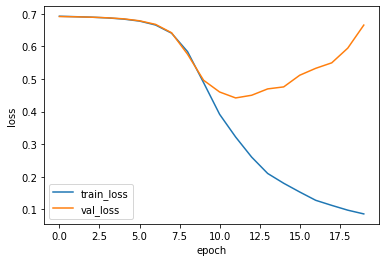

In [13]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

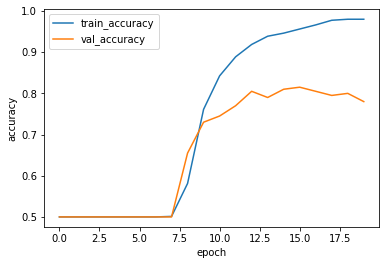

In [14]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [15]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

In [16]:
confusion_matrix(y_test, y_pred)

array([[79, 21],
       [23, 77]], dtype=int64)

In [17]:
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.77      0.79      0.78       100
    positive       0.79      0.77      0.78       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



In [18]:
# 4 Build a second RNN model using embedding layer and LSTM and evaluate it on the test dataset.
model = tf.keras.Sequential([
    encoder, 
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [20]:
%%time
history = model.fit(x=X_train, y=y_train, batch_size= 32, epochs= 20,
          validation_data=(X_test,y_test), verbose= 1)

Epoch 1/20
25/25 [==============================] - 13s 165ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 1s 35ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 3/20
25/25 [==============================] - 1s 38ms/step - loss: 0.6892 - accuracy: 0.5000 - val_loss: 0.6878 - val_accuracy: 0.5000
Epoch 4/20
25/25 [==============================] - 1s 37ms/step - loss: 0.6852 - accuracy: 0.5000 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 5/20
25/25 [==============================] - 1s 36ms/step - loss: 0.6768 - accuracy: 0.5000 - val_loss: 0.6718 - val_accuracy: 0.5000
Epoch 6/20
25/25 [==============================] - 1s 34ms/step - loss: 0.6558 - accuracy: 0.5000 - val_loss: 0.6438 - val_accuracy: 0.5000
Epoch 7/20
25/25 [==============================] - 1s 40ms/step - loss: 0.5974 - accuracy: 0.5375 - val_loss: 0.5723 - val_accuracy: 0.6050
Epoch 8/20


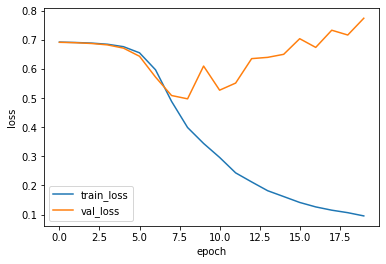

In [21]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

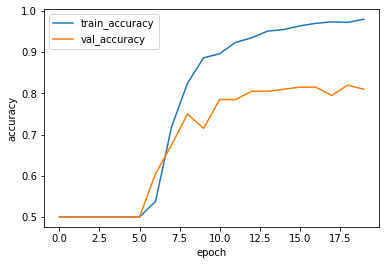

In [22]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [23]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

In [24]:
confusion_matrix(y_test, y_pred)

array([[84, 16],
       [22, 78]], dtype=int64)

In [25]:
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.79      0.84      0.82       100
    positive       0.83      0.78      0.80       100

    accuracy                           0.81       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.81      0.81      0.81       200



In [26]:
# 5 Build a third RNN model using embedding layer and GRU and LSTM and evaluate it on the test dataset.
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
%%time
history = model.fit(x=X_train, y=y_train, batch_size= 32, epochs= 20,
          validation_data=(X_test,y_test), verbose= 1)

Epoch 1/20
25/25 [==============================] - 18s 244ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 1s 57ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 3/20
25/25 [==============================] - 1s 58ms/step - loss: 0.6888 - accuracy: 0.5000 - val_loss: 0.6873 - val_accuracy: 0.5000
Epoch 4/20
25/25 [==============================] - 1s 58ms/step - loss: 0.6797 - accuracy: 0.5000 - val_loss: 0.6750 - val_accuracy: 0.5000
Epoch 5/20
25/25 [==============================] - 2s 62ms/step - loss: 0.6448 - accuracy: 0.5050 - val_loss: 0.6253 - val_accuracy: 0.5100
Epoch 6/20
25/25 [==============================] - 1s 59ms/step - loss: 0.5331 - accuracy: 0.6600 - val_loss: 0.5423 - val_accuracy: 0.6650
Epoch 7/20
25/25 [==============================] - 1s 57ms/step - loss: 0.4001 - accuracy: 0.8175 - val_loss: 0.5428 - val_accuracy: 0.7150
Epoch 8/20


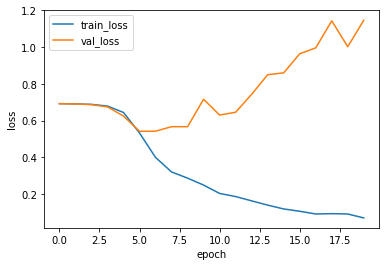

In [29]:
train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch

sns.lineplot(x='epoch', y ='loss', data =train_history)
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
plt.legend(labels=['train_loss', 'val_loss'])

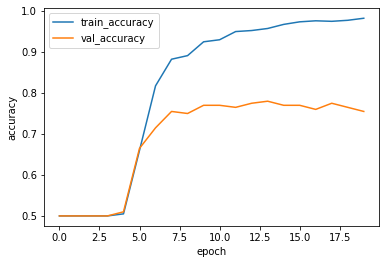

In [30]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
plt.legend(labels=['train_accuracy', 'val_accuracy'])

In [31]:
y_pred = (model.predict(X_test) > 0.5).astype(int)

In [32]:
confusion_matrix(y_test, y_pred)

array([[78, 22],
       [27, 73]], dtype=int64)

In [33]:
label_names = ['negative', 'positive']
print(classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

    negative       0.74      0.78      0.76       100
    positive       0.77      0.73      0.75       100

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.75       200
weighted avg       0.76      0.76      0.75       200



In [34]:
# 6 Which model do you recommend for the model in Q3, Q4, and Q5? Justify your answer.
# I would recommend the model from Q4, as the accuracy was 0.81. The accuracy of Q3 was only 0.78, and the accuracy of Q5 was
# only 0.76.